In [1]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.dynamics as gd
import gala.potential as gp
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize_scalar
from matplotlib.patches import Ellipse
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

Helper Functions

In [2]:
def sample(dict, n_samples=1):
    ra = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    sc = coord.SkyCoord(ra=ra * u.degree,
                dec=dec * u.degree,
                distance=dist * u.kpc,
                pm_ra_cosdec=pmra * (u.mas / u.yr),
                pm_dec=pmdec * (u.mas / u.yr),
                radial_velocity=rv * (u.km / u.s),
                frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    return ics

def minimize(num_steps, ics1, ics2):
    orbit1 = pot.integrate_orbit(ics1, dt=-0.1*u.Myr, n_steps=num_steps)
    orbit2 = pot.integrate_orbit(ics2, dt=-0.1*u.Myr, n_steps=num_steps)
    final_pos1 = orbit1[-1].pos.xyz.to(u.kpc).value[:3]
    final_pos2 = orbit2[-1].pos.xyz.to(u.kpc).value[:3]
    distance = np.linalg.norm(final_pos1 - final_pos2)
    return distance

First, define a gravitational potential.

In [3]:
pot = gp.MilkyWayPotential()

Hydra II

In [4]:
dwarf_dict = {
    'ra': 185.425, #degree
    'e_ra': 0.01, #degree
    'dec': -31.9853, #degree
    'e_dec': 0.01, #degree
    'dist': 151.0, #kpc
    'e_dist': 7.5, #kpc
    'pmra': -0.34, #mas/yr
    'e_pmra': 0.01, #mas/yr
    'pmdec': -0.09, #mas/yr
    'e_pmdec': 0.085, #mas/yr
    'rv': 303.1, #km/s
    'e_rv': 1.4, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dwarf_dict['ra'] * u.degree,
    dec=dwarf_dict['dec'] * u.degree,
    distance=dwarf_dict['dist'] * u.kpc,
    pm_ra_cosdec=dwarf_dict['pmra'] * (u.mas / u.yr),
    pm_dec=dwarf_dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dwarf_dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

        Use name instead. [gala.dynamics.core]


HVS 14

In [5]:
dict = {
    'name': 'hvs14',
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs = coord.SkyCoord(
    ra=dict['ra'] * u.degree,
    dec=dict['dec'] * u.degree,
    distance=dict['dist'] * u.kpc,
    pm_ra_cosdec=dict['pmra'] * (u.mas / u.yr),
    pm_dec=dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs_GC = hvs.transform_to(coord.Galactocentric)
hvs_ics = gd.PhaseSpacePosition(pos=hvs_GC.cartesian.xyz, vel=hvs_GC.velocity.d_xyz)

Galaxy Plot

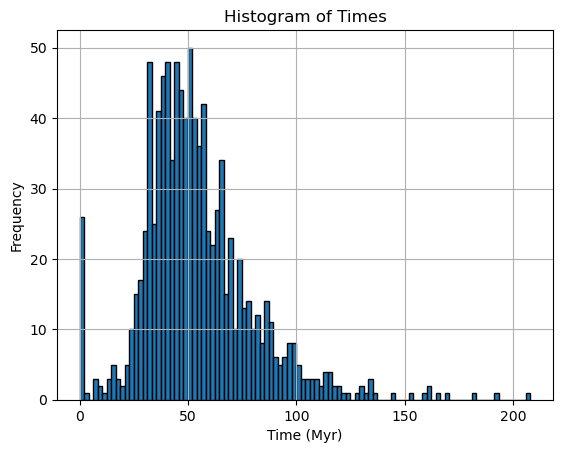

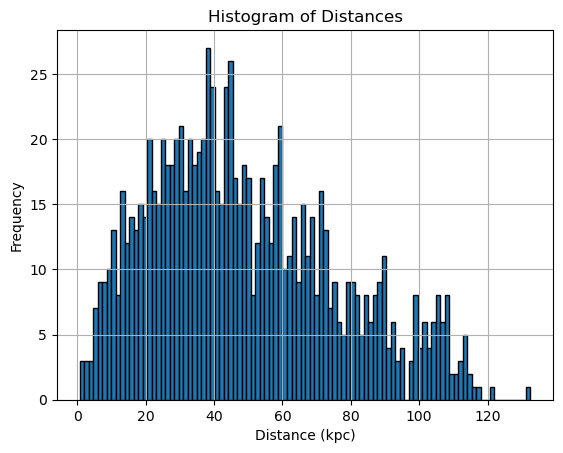

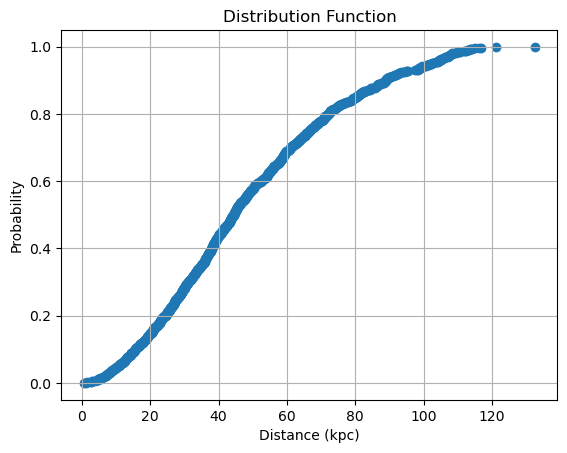

In [6]:
count = 1000
times = []
distances = []

while count > 0:
    dwarf_sample = sample(dwarf_dict)
    hvs_sample = sample(dict)

    result = minimize_scalar(
        minimize,
        args=(dwarf_sample, hvs_sample),
        bounds=(0, 8000),  # search between 0 and 8000 steps (800 Myr)
        method='bounded'
    )
    time = int(result.x)*0.1
    distance = minimize(result.x, dwarf_sample, hvs_sample)

    times.append(time)
    distances.append(distance)
    count -= 1

counts = []

for val in distances:
    count = sum(d < val for d in distances)
    counts.append(count)

# Plot
plt.hist(times, bins=100, edgecolor='black')
plt.xlabel('Time (Myr)')
plt.ylabel('Frequency')
plt.title('Histogram of Times')
plt.grid(True)
plt.show()

# Plot
plt.hist(distances, bins=100, edgecolor='black')
plt.xlabel('Distance (kpc)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.grid(True)
plt.show()

# Plot
plt.scatter(distances, np.array(counts)/(len(times)))
plt.xlabel('Distance (kpc)')
plt.ylabel('Probability')
plt.title('Distribution Function')
plt.grid(True)
plt.show()